# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:09<00:00, 6.05KFile/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

/home/carnd/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/home/carnd/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


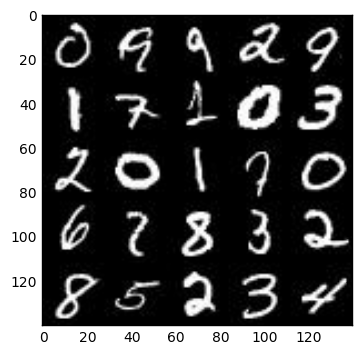

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

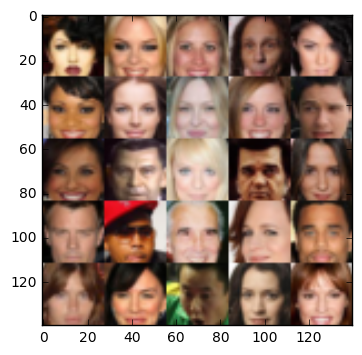

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [20]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_height, image_width, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learn_rate = tf.placeholder(tf.float32, name='learn_rate')

    return inputs_real, inputs_z, learn_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [45]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same',
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        x1 = tf.maximum(alpha * x1, x1)
        #14*14*64
        
        x2 = tf.layers.conv2d(x1, 128, 5, strides=2, padding='same',
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha * x2, x2)
        #7*7*128
        
        x3 = tf.layers.conv2d(x2, 256, 5, strides=2, padding='same',
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha * x3, x3)
        #4*4*256
        
        flat = tf.reshape(x3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [46]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('generator', reuse=not is_train):
        x1 = tf.layers.dense(z, 2*2*512)
        x1 = tf.reshape(x1, (-1, 2, 2, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.nn.relu(x1)
        #4*4*512
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='valid',
                                        kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.nn.relu(x2)
        #7*7*256
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same',
                                        kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.nn.relu(x3)
        #14*14*128
        
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same',
                                            kernel_initializer=tf.contrib.layers.xavier_initializer())
        
        out = tf.tanh(logits)*0.5
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [47]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    smooth = 0.1
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                                         labels=tf.ones_like(d_model_real)*(1 - smooth)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                                         labels=tf.zeros_like(d_model_fake)))
    d_loss = d_loss_fake + d_loss_real
    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                                    labels=tf.ones_like(d_model_fake)))
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [51]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [52]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [61]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    n_samples, height, width, channel = data_shape
    input_real, input_z, learn_rate = model_inputs(width, height, channel, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, channel)
    d_opt, g_opt = model_opt(d_loss, g_loss, learn_rate, beta1)
    
    steps = 0
    print_every = 20
    show_every = 300
    
    saver = tf.train.Saver()
    losses = []
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate:learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate:learning_rate})
                
                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({input_real: batch_images, input_z: batch_z})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))
                    
                if steps % show_every == 0:
                    n_images = 25
                    show_generator_output(sess, n_images, input_z, channel, data_image_mode)
                    
        saver.save(sess, './checkpoints/generator.ckpt')       

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 0/2... Discriminator Loss: 0.4565... Generator Loss: 5.5757
Epoch 0/2... Discriminator Loss: 0.4330... Generator Loss: 6.1136
Epoch 0/2... Discriminator Loss: 0.4024... Generator Loss: 3.1694
Epoch 0/2... Discriminator Loss: 0.3780... Generator Loss: 4.2275
Epoch 0/2... Discriminator Loss: 1.1380... Generator Loss: 3.3048
Epoch 0/2... Discriminator Loss: 1.3126... Generator Loss: 0.7033
Epoch 0/2... Discriminator Loss: 0.6996... Generator Loss: 2.5678
Epoch 0/2... Discriminator Loss: 0.7597... Generator Loss: 1.3414
Epoch 0/2... Discriminator Loss: 0.5135... Generator Loss: 5.7110
Epoch 0/2... Discriminator Loss: 1.1272... Generator Loss: 6.4462
Epoch 0/2... Discriminator Loss: 0.5061... Generator Loss: 2.6100
Epoch 0/2... Discriminator Loss: 0.4867... Generator Loss: 3.6482
Epoch 0/2... Discriminator Loss: 0.7595... Generator Loss: 1.8230
Epoch 0/2... Discriminator Loss: 0.4717... Generator Loss: 3.9165
Epoch 0/2... Discriminator Loss: 0.5680... Generator Loss: 1.8749


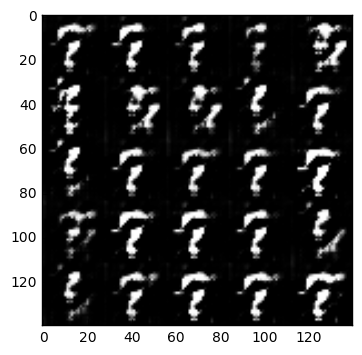

Epoch 0/2... Discriminator Loss: 0.5233... Generator Loss: 2.3947
Epoch 0/2... Discriminator Loss: 0.4908... Generator Loss: 3.6920
Epoch 0/2... Discriminator Loss: 0.4580... Generator Loss: 3.2387
Epoch 0/2... Discriminator Loss: 0.4886... Generator Loss: 2.8909
Epoch 0/2... Discriminator Loss: 0.5273... Generator Loss: 3.1505
Epoch 0/2... Discriminator Loss: 0.5294... Generator Loss: 6.8837
Epoch 0/2... Discriminator Loss: 0.6912... Generator Loss: 1.5016
Epoch 0/2... Discriminator Loss: 0.5525... Generator Loss: 2.9630
Epoch 0/2... Discriminator Loss: 0.6981... Generator Loss: 1.5193
Epoch 0/2... Discriminator Loss: 0.5281... Generator Loss: 2.6118
Epoch 0/2... Discriminator Loss: 0.8852... Generator Loss: 4.8119
Epoch 0/2... Discriminator Loss: 0.7246... Generator Loss: 1.8339
Epoch 0/2... Discriminator Loss: 0.7863... Generator Loss: 1.7516
Epoch 0/2... Discriminator Loss: 0.6562... Generator Loss: 2.1513
Epoch 0/2... Discriminator Loss: 0.6308... Generator Loss: 2.3890


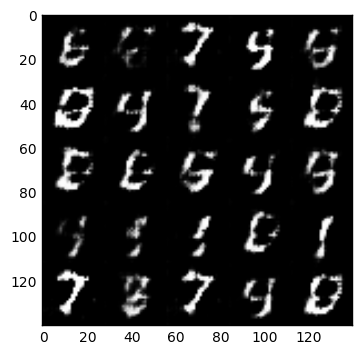

Epoch 0/2... Discriminator Loss: 0.8632... Generator Loss: 1.5426
Epoch 0/2... Discriminator Loss: 0.6006... Generator Loss: 3.3207
Epoch 0/2... Discriminator Loss: 0.9692... Generator Loss: 1.2699
Epoch 0/2... Discriminator Loss: 0.6962... Generator Loss: 1.9058
Epoch 0/2... Discriminator Loss: 0.6778... Generator Loss: 2.1123
Epoch 0/2... Discriminator Loss: 0.7862... Generator Loss: 1.3278
Epoch 0/2... Discriminator Loss: 1.0281... Generator Loss: 1.0817
Epoch 0/2... Discriminator Loss: 0.9256... Generator Loss: 1.8403
Epoch 0/2... Discriminator Loss: 1.1416... Generator Loss: 0.8852
Epoch 0/2... Discriminator Loss: 0.9787... Generator Loss: 1.0812
Epoch 0/2... Discriminator Loss: 0.7008... Generator Loss: 2.8770
Epoch 0/2... Discriminator Loss: 0.6901... Generator Loss: 2.7475
Epoch 0/2... Discriminator Loss: 0.7219... Generator Loss: 2.4708
Epoch 0/2... Discriminator Loss: 1.1513... Generator Loss: 2.6566
Epoch 0/2... Discriminator Loss: 0.8689... Generator Loss: 1.9168


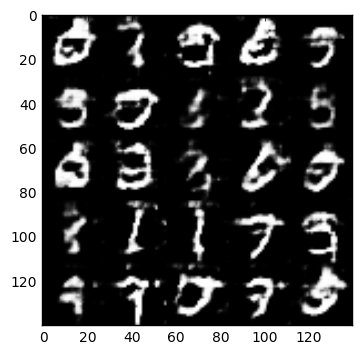

Epoch 0/2... Discriminator Loss: 0.8487... Generator Loss: 1.5377
Epoch 1/2... Discriminator Loss: 1.0298... Generator Loss: 0.9970
Epoch 1/2... Discriminator Loss: 1.0275... Generator Loss: 1.0095
Epoch 1/2... Discriminator Loss: 0.9284... Generator Loss: 2.4061
Epoch 1/2... Discriminator Loss: 0.8869... Generator Loss: 2.1514
Epoch 1/2... Discriminator Loss: 0.9300... Generator Loss: 2.7636
Epoch 1/2... Discriminator Loss: 0.7806... Generator Loss: 1.9860
Epoch 1/2... Discriminator Loss: 0.9012... Generator Loss: 1.2038
Epoch 1/2... Discriminator Loss: 0.8593... Generator Loss: 1.2227
Epoch 1/2... Discriminator Loss: 1.1033... Generator Loss: 0.9455
Epoch 1/2... Discriminator Loss: 1.1174... Generator Loss: 1.9922
Epoch 1/2... Discriminator Loss: 1.0110... Generator Loss: 1.7828
Epoch 1/2... Discriminator Loss: 0.9840... Generator Loss: 1.7519
Epoch 1/2... Discriminator Loss: 0.9050... Generator Loss: 1.5959
Epoch 1/2... Discriminator Loss: 1.0045... Generator Loss: 1.0923


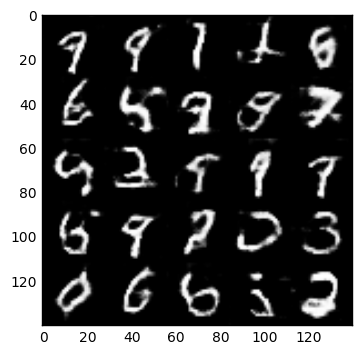

Epoch 1/2... Discriminator Loss: 1.1621... Generator Loss: 0.7269
Epoch 1/2... Discriminator Loss: 0.8981... Generator Loss: 2.0753
Epoch 1/2... Discriminator Loss: 1.0512... Generator Loss: 0.8840
Epoch 1/2... Discriminator Loss: 0.9119... Generator Loss: 1.2858
Epoch 1/2... Discriminator Loss: 0.9764... Generator Loss: 1.9308
Epoch 1/2... Discriminator Loss: 1.0324... Generator Loss: 1.6569
Epoch 1/2... Discriminator Loss: 0.9324... Generator Loss: 1.1040
Epoch 1/2... Discriminator Loss: 1.0169... Generator Loss: 1.6574
Epoch 1/2... Discriminator Loss: 1.5992... Generator Loss: 0.4365
Epoch 1/2... Discriminator Loss: 1.0482... Generator Loss: 1.2950
Epoch 1/2... Discriminator Loss: 1.2275... Generator Loss: 2.2975
Epoch 1/2... Discriminator Loss: 1.5992... Generator Loss: 0.4173
Epoch 1/2... Discriminator Loss: 1.1278... Generator Loss: 0.7476
Epoch 1/2... Discriminator Loss: 1.0554... Generator Loss: 1.1401
Epoch 1/2... Discriminator Loss: 1.0119... Generator Loss: 1.1647


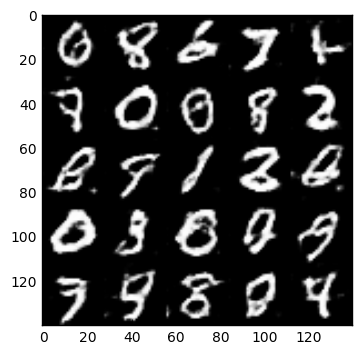

Epoch 1/2... Discriminator Loss: 1.1005... Generator Loss: 0.8988
Epoch 1/2... Discriminator Loss: 1.2408... Generator Loss: 2.1801
Epoch 1/2... Discriminator Loss: 1.1392... Generator Loss: 0.7569
Epoch 1/2... Discriminator Loss: 1.1487... Generator Loss: 0.6985
Epoch 1/2... Discriminator Loss: 1.1318... Generator Loss: 0.8368
Epoch 1/2... Discriminator Loss: 1.2966... Generator Loss: 0.7965
Epoch 1/2... Discriminator Loss: 1.2152... Generator Loss: 0.7671
Epoch 1/2... Discriminator Loss: 1.1455... Generator Loss: 1.1736
Epoch 1/2... Discriminator Loss: 1.7057... Generator Loss: 2.8819
Epoch 1/2... Discriminator Loss: 1.1216... Generator Loss: 0.8304
Epoch 1/2... Discriminator Loss: 1.0150... Generator Loss: 1.7229
Epoch 1/2... Discriminator Loss: 1.0893... Generator Loss: 1.3121
Epoch 1/2... Discriminator Loss: 2.3978... Generator Loss: 3.7846
Epoch 1/2... Discriminator Loss: 1.0596... Generator Loss: 0.9384
Epoch 1/2... Discriminator Loss: 1.4446... Generator Loss: 0.5068


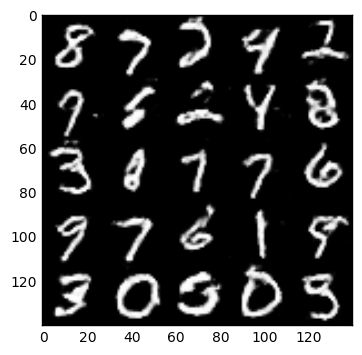

Epoch 1/2... Discriminator Loss: 1.1641... Generator Loss: 0.8639
Epoch 1/2... Discriminator Loss: 1.1334... Generator Loss: 0.7694
Epoch 1/2... Discriminator Loss: 1.2011... Generator Loss: 2.0660


In [62]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 0/1... Discriminator Loss: 0.9109... Generator Loss: 11.8397
Epoch 0/1... Discriminator Loss: 2.1647... Generator Loss: 0.2068
Epoch 0/1... Discriminator Loss: 1.6245... Generator Loss: 0.4519
Epoch 0/1... Discriminator Loss: 0.7411... Generator Loss: 3.1569
Epoch 0/1... Discriminator Loss: 0.5582... Generator Loss: 2.8005
Epoch 0/1... Discriminator Loss: 1.1834... Generator Loss: 1.9547
Epoch 0/1... Discriminator Loss: 1.0205... Generator Loss: 0.9950
Epoch 0/1... Discriminator Loss: 1.0824... Generator Loss: 1.7500
Epoch 0/1... Discriminator Loss: 1.1768... Generator Loss: 4.0945
Epoch 0/1... Discriminator Loss: 1.1699... Generator Loss: 0.9855
Epoch 0/1... Discriminator Loss: 1.4936... Generator Loss: 2.2563
Epoch 0/1... Discriminator Loss: 1.3196... Generator Loss: 0.7326
Epoch 0/1... Discriminator Loss: 1.1435... Generator Loss: 0.8128
Epoch 0/1... Discriminator Loss: 0.7956... Generator Loss: 2.4033
Epoch 0/1... Discriminator Loss: 0.9366... Generator Loss: 1.0557


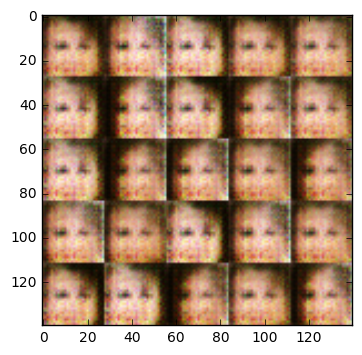

Epoch 0/1... Discriminator Loss: 0.6116... Generator Loss: 3.2067
Epoch 0/1... Discriminator Loss: 0.7984... Generator Loss: 2.7031
Epoch 0/1... Discriminator Loss: 1.7919... Generator Loss: 6.6437
Epoch 0/1... Discriminator Loss: 0.9736... Generator Loss: 1.4724
Epoch 0/1... Discriminator Loss: 0.5735... Generator Loss: 2.2923
Epoch 0/1... Discriminator Loss: 0.6659... Generator Loss: 5.1045
Epoch 0/1... Discriminator Loss: 0.5201... Generator Loss: 2.4811
Epoch 0/1... Discriminator Loss: 0.8540... Generator Loss: 1.1220
Epoch 0/1... Discriminator Loss: 0.8526... Generator Loss: 1.2730
Epoch 0/1... Discriminator Loss: 0.7224... Generator Loss: 3.4570
Epoch 0/1... Discriminator Loss: 1.0476... Generator Loss: 0.9453
Epoch 0/1... Discriminator Loss: 0.7043... Generator Loss: 1.6819
Epoch 0/1... Discriminator Loss: 0.6970... Generator Loss: 2.0862
Epoch 0/1... Discriminator Loss: 1.0364... Generator Loss: 1.3250
Epoch 0/1... Discriminator Loss: 0.9586... Generator Loss: 1.1858


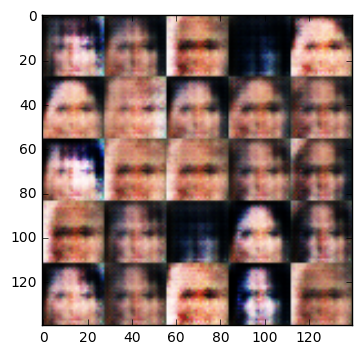

Epoch 0/1... Discriminator Loss: 0.7777... Generator Loss: 1.5162
Epoch 0/1... Discriminator Loss: 1.4037... Generator Loss: 0.5491
Epoch 0/1... Discriminator Loss: 0.6062... Generator Loss: 2.5002
Epoch 0/1... Discriminator Loss: 1.4588... Generator Loss: 0.4994
Epoch 0/1... Discriminator Loss: 1.2191... Generator Loss: 0.8063
Epoch 0/1... Discriminator Loss: 0.9680... Generator Loss: 1.3866
Epoch 0/1... Discriminator Loss: 0.5039... Generator Loss: 2.5848
Epoch 0/1... Discriminator Loss: 1.2409... Generator Loss: 1.0706
Epoch 0/1... Discriminator Loss: 0.9228... Generator Loss: 1.2106
Epoch 0/1... Discriminator Loss: 1.2130... Generator Loss: 0.6925
Epoch 0/1... Discriminator Loss: 1.8568... Generator Loss: 0.3093
Epoch 0/1... Discriminator Loss: 0.8872... Generator Loss: 1.2785
Epoch 0/1... Discriminator Loss: 0.7152... Generator Loss: 2.1493
Epoch 0/1... Discriminator Loss: 0.7699... Generator Loss: 3.0737
Epoch 0/1... Discriminator Loss: 0.6156... Generator Loss: 1.8493


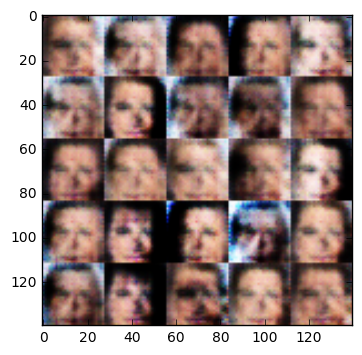

Epoch 0/1... Discriminator Loss: 1.0515... Generator Loss: 0.8632
Epoch 0/1... Discriminator Loss: 0.7744... Generator Loss: 3.2262
Epoch 0/1... Discriminator Loss: 0.7640... Generator Loss: 1.8101
Epoch 0/1... Discriminator Loss: 0.9474... Generator Loss: 1.0977
Epoch 0/1... Discriminator Loss: 0.9635... Generator Loss: 1.1006
Epoch 0/1... Discriminator Loss: 0.8434... Generator Loss: 1.7400
Epoch 0/1... Discriminator Loss: 1.2417... Generator Loss: 3.7555
Epoch 0/1... Discriminator Loss: 1.1614... Generator Loss: 0.7676
Epoch 0/1... Discriminator Loss: 0.8408... Generator Loss: 1.8074
Epoch 0/1... Discriminator Loss: 0.6931... Generator Loss: 2.0841
Epoch 0/1... Discriminator Loss: 0.8631... Generator Loss: 1.1735
Epoch 0/1... Discriminator Loss: 0.6547... Generator Loss: 2.1433
Epoch 0/1... Discriminator Loss: 0.9934... Generator Loss: 0.9497
Epoch 0/1... Discriminator Loss: 1.4085... Generator Loss: 0.5121
Epoch 0/1... Discriminator Loss: 0.9612... Generator Loss: 1.0981


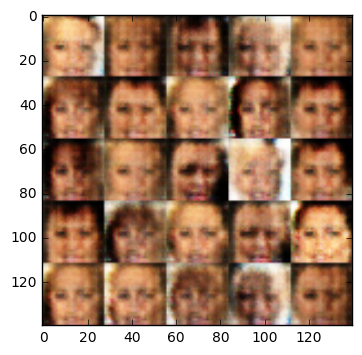

Epoch 0/1... Discriminator Loss: 0.8894... Generator Loss: 1.1982
Epoch 0/1... Discriminator Loss: 0.6153... Generator Loss: 1.7497
Epoch 0/1... Discriminator Loss: 1.3713... Generator Loss: 0.6230
Epoch 0/1... Discriminator Loss: 0.7151... Generator Loss: 2.8244
Epoch 0/1... Discriminator Loss: 0.7397... Generator Loss: 1.5121
Epoch 0/1... Discriminator Loss: 0.6301... Generator Loss: 1.8581
Epoch 0/1... Discriminator Loss: 1.3299... Generator Loss: 0.6114
Epoch 0/1... Discriminator Loss: 0.7952... Generator Loss: 2.0073
Epoch 0/1... Discriminator Loss: 0.6509... Generator Loss: 2.1982
Epoch 0/1... Discriminator Loss: 0.7968... Generator Loss: 1.6386
Epoch 0/1... Discriminator Loss: 0.6799... Generator Loss: 2.0247
Epoch 0/1... Discriminator Loss: 1.0216... Generator Loss: 1.3765
Epoch 0/1... Discriminator Loss: 0.6704... Generator Loss: 1.9203
Epoch 0/1... Discriminator Loss: 1.0041... Generator Loss: 1.0690
Epoch 0/1... Discriminator Loss: 0.8244... Generator Loss: 1.2940


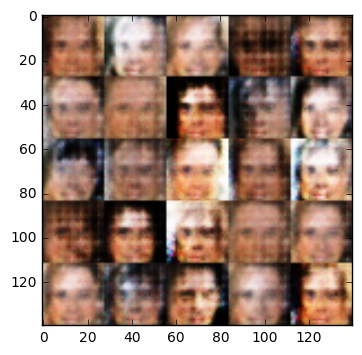

Epoch 0/1... Discriminator Loss: 0.9260... Generator Loss: 1.0614
Epoch 0/1... Discriminator Loss: 1.1116... Generator Loss: 1.0632
Epoch 0/1... Discriminator Loss: 0.8995... Generator Loss: 1.4229
Epoch 0/1... Discriminator Loss: 0.9688... Generator Loss: 2.1406
Epoch 0/1... Discriminator Loss: 0.9840... Generator Loss: 1.8820
Epoch 0/1... Discriminator Loss: 0.8694... Generator Loss: 1.2005
Epoch 0/1... Discriminator Loss: 0.6672... Generator Loss: 2.5385
Epoch 0/1... Discriminator Loss: 0.6839... Generator Loss: 2.0409
Epoch 0/1... Discriminator Loss: 0.6782... Generator Loss: 1.6374
Epoch 0/1... Discriminator Loss: 0.9307... Generator Loss: 1.1854
Epoch 0/1... Discriminator Loss: 1.3971... Generator Loss: 3.2359
Epoch 0/1... Discriminator Loss: 0.9770... Generator Loss: 2.2808
Epoch 0/1... Discriminator Loss: 1.1168... Generator Loss: 2.2584
Epoch 0/1... Discriminator Loss: 0.8707... Generator Loss: 1.2033
Epoch 0/1... Discriminator Loss: 1.0559... Generator Loss: 0.9765


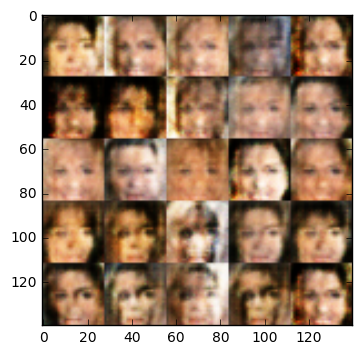

Epoch 0/1... Discriminator Loss: 0.7314... Generator Loss: 1.4087
Epoch 0/1... Discriminator Loss: 1.1848... Generator Loss: 0.7604
Epoch 0/1... Discriminator Loss: 0.7221... Generator Loss: 1.6586
Epoch 0/1... Discriminator Loss: 1.1090... Generator Loss: 2.9298
Epoch 0/1... Discriminator Loss: 0.7589... Generator Loss: 2.0098
Epoch 0/1... Discriminator Loss: 1.2091... Generator Loss: 1.7260
Epoch 0/1... Discriminator Loss: 1.0148... Generator Loss: 1.0093
Epoch 0/1... Discriminator Loss: 0.7981... Generator Loss: 1.3266
Epoch 0/1... Discriminator Loss: 1.3610... Generator Loss: 4.2029
Epoch 0/1... Discriminator Loss: 0.6946... Generator Loss: 1.7070
Epoch 0/1... Discriminator Loss: 0.8159... Generator Loss: 1.6196
Epoch 0/1... Discriminator Loss: 1.0190... Generator Loss: 0.9658
Epoch 0/1... Discriminator Loss: 0.9360... Generator Loss: 2.8125
Epoch 0/1... Discriminator Loss: 1.0053... Generator Loss: 1.0723
Epoch 0/1... Discriminator Loss: 0.9583... Generator Loss: 2.7685


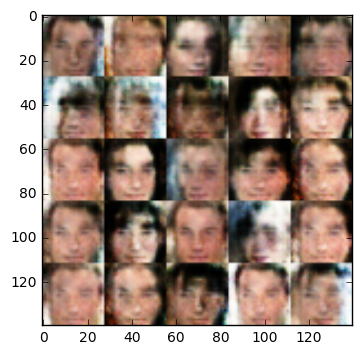

Epoch 0/1... Discriminator Loss: 1.1216... Generator Loss: 1.7873
Epoch 0/1... Discriminator Loss: 0.8148... Generator Loss: 1.7600
Epoch 0/1... Discriminator Loss: 0.7952... Generator Loss: 1.7035
Epoch 0/1... Discriminator Loss: 0.7809... Generator Loss: 1.6615
Epoch 0/1... Discriminator Loss: 0.9476... Generator Loss: 1.1129
Epoch 0/1... Discriminator Loss: 0.7629... Generator Loss: 1.6388
Epoch 0/1... Discriminator Loss: 0.9607... Generator Loss: 2.0756
Epoch 0/1... Discriminator Loss: 1.0333... Generator Loss: 0.8949
Epoch 0/1... Discriminator Loss: 0.8532... Generator Loss: 1.1903
Epoch 0/1... Discriminator Loss: 0.8419... Generator Loss: 2.6672
Epoch 0/1... Discriminator Loss: 1.1992... Generator Loss: 0.8253
Epoch 0/1... Discriminator Loss: 0.9944... Generator Loss: 2.7543
Epoch 0/1... Discriminator Loss: 0.8638... Generator Loss: 1.7620
Epoch 0/1... Discriminator Loss: 0.8979... Generator Loss: 1.6207
Epoch 0/1... Discriminator Loss: 0.9828... Generator Loss: 0.9995


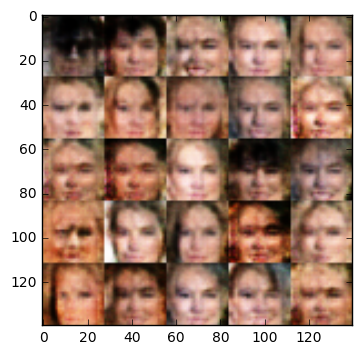

Epoch 0/1... Discriminator Loss: 0.9095... Generator Loss: 1.2765
Epoch 0/1... Discriminator Loss: 0.9085... Generator Loss: 1.2653
Epoch 0/1... Discriminator Loss: 1.0582... Generator Loss: 2.8306
Epoch 0/1... Discriminator Loss: 0.7952... Generator Loss: 2.4094
Epoch 0/1... Discriminator Loss: 0.8366... Generator Loss: 1.3564
Epoch 0/1... Discriminator Loss: 0.8270... Generator Loss: 1.8643
Epoch 0/1... Discriminator Loss: 2.2712... Generator Loss: 0.2187
Epoch 0/1... Discriminator Loss: 1.2692... Generator Loss: 2.8480
Epoch 0/1... Discriminator Loss: 0.7726... Generator Loss: 1.5451
Epoch 0/1... Discriminator Loss: 1.7687... Generator Loss: 0.3944
Epoch 0/1... Discriminator Loss: 0.9318... Generator Loss: 1.4096
Epoch 0/1... Discriminator Loss: 0.8756... Generator Loss: 1.3045
Epoch 0/1... Discriminator Loss: 0.8823... Generator Loss: 1.7380
Epoch 0/1... Discriminator Loss: 0.7876... Generator Loss: 1.7213
Epoch 0/1... Discriminator Loss: 0.7522... Generator Loss: 1.6326


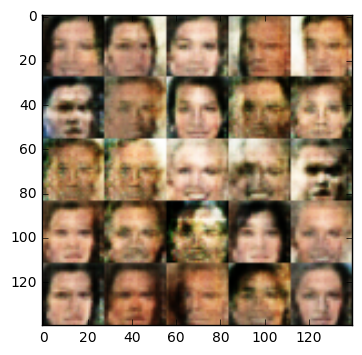

Epoch 0/1... Discriminator Loss: 2.3390... Generator Loss: 6.7692
Epoch 0/1... Discriminator Loss: 0.8546... Generator Loss: 1.3659
Epoch 0/1... Discriminator Loss: 0.8640... Generator Loss: 1.5426
Epoch 0/1... Discriminator Loss: 1.0322... Generator Loss: 0.8976
Epoch 0/1... Discriminator Loss: 0.7245... Generator Loss: 2.1164
Epoch 0/1... Discriminator Loss: 0.7414... Generator Loss: 1.7426
Epoch 0/1... Discriminator Loss: 0.8772... Generator Loss: 3.1156
Epoch 0/1... Discriminator Loss: 0.9227... Generator Loss: 1.1388
Epoch 0/1... Discriminator Loss: 0.8683... Generator Loss: 1.4758
Epoch 0/1... Discriminator Loss: 0.9647... Generator Loss: 1.5184
Epoch 0/1... Discriminator Loss: 0.9038... Generator Loss: 1.0755
Epoch 0/1... Discriminator Loss: 0.8457... Generator Loss: 2.2891
Epoch 0/1... Discriminator Loss: 1.2881... Generator Loss: 0.6471
Epoch 0/1... Discriminator Loss: 1.1976... Generator Loss: 0.7023
Epoch 0/1... Discriminator Loss: 0.7829... Generator Loss: 1.8593


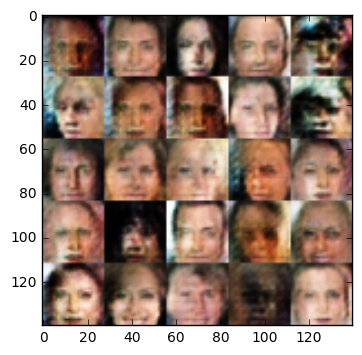

Epoch 0/1... Discriminator Loss: 0.7245... Generator Loss: 2.2887
Epoch 0/1... Discriminator Loss: 0.8492... Generator Loss: 1.2848
Epoch 0/1... Discriminator Loss: 0.9610... Generator Loss: 0.9787
Epoch 0/1... Discriminator Loss: 0.8509... Generator Loss: 1.3999
Epoch 0/1... Discriminator Loss: 0.9777... Generator Loss: 1.3532
Epoch 0/1... Discriminator Loss: 0.9118... Generator Loss: 2.3284
Epoch 0/1... Discriminator Loss: 0.9329... Generator Loss: 1.1236
Epoch 0/1... Discriminator Loss: 1.0742... Generator Loss: 0.8029


In [65]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.